# **ING Business Case**
    by Paweł Czapla


In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2025-02-26 17:45:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip.4’

NewsAggregatorDatas     [               <=>  ]  27.87M  6.63MB/s    in 4.9s    

2025-02-26 17:45:38 (5.64 MB/s) - ‘NewsAggregatorDataset.zip.4’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ing_business_case").getOrCreate()

# EDA & Feature selection

## 1. Inspecting and Renaming Columns
After loading the dataset, the structure of the data is examined.

Once the schema is validated, meaningful column names are assigned to improve readability.

In [4]:
df = spark.read.csv("newsCorpora.csv", sep="\t", header=False, inferSchema=True)

df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: long (nullable = true)



In [5]:
df.show(5)

+---+--------------------+--------------------+-----------------+---+--------------------+-------------------+-------------+
|_c0|                 _c1|                 _c2|              _c3|_c4|                 _c5|                _c6|          _c7|
+---+--------------------+--------------------+-----------------+---+--------------------+-------------------+-------------+
|  1|Fed official says...|http://www.latime...|Los Angeles Times|  b|ddUyU0VZz0BRneMio...|    www.latimes.com|1394470370698|
|  2|Fed's Charles Plo...|http://www.livemi...|         Livemint|  b|ddUyU0VZz0BRneMio...|   www.livemint.com|1394470371207|
|  3|US open: Stocks f...|http://www.ifamag...|     IFA Magazine|  b|ddUyU0VZz0BRneMio...|www.ifamagazine.com|1394470371550|
|  4|Fed risks falling...|http://www.ifamag...|     IFA Magazine|  b|ddUyU0VZz0BRneMio...|www.ifamagazine.com|1394470371793|
|  5|Fed's Plosser: Na...|http://www.moneyn...|        Moneynews|  b|ddUyU0VZz0BRneMio...|  www.moneynews.com|1394470372027|


In [6]:
df = df.toDF("ID", "Title", "URL", "Publisher", "Category", "Story", "Hostname", "Timestamp")

df.show(5)

+---+--------------------+--------------------+-----------------+--------+--------------------+-------------------+-------------+
| ID|               Title|                 URL|        Publisher|Category|               Story|           Hostname|    Timestamp|
+---+--------------------+--------------------+-----------------+--------+--------------------+-------------------+-------------+
|  1|Fed official says...|http://www.latime...|Los Angeles Times|       b|ddUyU0VZz0BRneMio...|    www.latimes.com|1394470370698|
|  2|Fed's Charles Plo...|http://www.livemi...|         Livemint|       b|ddUyU0VZz0BRneMio...|   www.livemint.com|1394470371207|
|  3|US open: Stocks f...|http://www.ifamag...|     IFA Magazine|       b|ddUyU0VZz0BRneMio...|www.ifamagazine.com|1394470371550|
|  4|Fed risks falling...|http://www.ifamag...|     IFA Magazine|       b|ddUyU0VZz0BRneMio...|www.ifamagazine.com|1394470371793|
|  5|Fed's Plosser: Na...|http://www.moneyn...|        Moneynews|       b|ddUyU0VZz0BRneMi

## 2. Feature Selection
Only the necessary columns are retained from the dataset.

The only columns that could affect classification would be ***Title*** and ***Publisher***.

For simplicity, the ***Publisher*** column was omitted, as it would not affect the result in a significant extent.

In [7]:
df = df.select("Title", "Category")

df.show(5, truncate=False)

+---------------------------------------------------------------------+--------+
|Title                                                                |Category|
+---------------------------------------------------------------------+--------+
|Fed official says weak data caused by weather, should not slow taper |b       |
|Fed's Charles Plosser sees high bar for change in pace of tapering   |b       |
|US open: Stocks fall after Fed official hints at accelerated tapering|b       |
|Fed risks falling 'behind the curve', Charles Plosser says           |b       |
|Fed's Plosser: Nasty Weather Has Curbed Job Growth                   |b       |
+---------------------------------------------------------------------+--------+
only showing top 5 rows



## 3. Removing Duplicate Entries
To ensure data integrity, duplicate records based on the ***Title*** column are removed.

This step prevents redundant information from skewing analysis and improves the accuracy of insights derived from the dataset.

In [8]:
df = df.dropDuplicates(["Title"])

## 4. Handling Missing Values
Records with missing values in the ***Title*** or ***Category*** columns are dropped from the dataset.

This ensures that subsequent analyses are performed on complete and meaningful data, preventing potential errors or misleading interpretations.

In [9]:
class_counts = df.groupBy("Category").count()
class_counts.show()

+--------+------+
|Category| count|
+--------+------+
|       m| 43633|
|    NULL|     9|
|       e|147190|
|       b|111668|
|       t|104440|
+--------+------+



In [10]:
df = df.dropna()

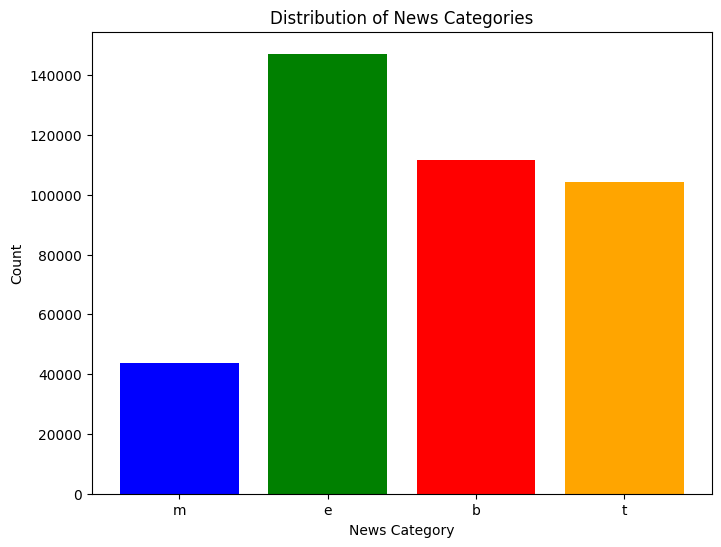

In [11]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

class_counts = df.groupBy("Category").count().toPandas()

plt.figure(figsize=(6, 4))
plt.bar(class_counts["Category"], class_counts["count"], color=['blue', 'green', 'red', 'orange'])
plt.xlabel("News Category")
plt.ylabel("Count")
plt.title("Distribution of News Categories")
plt.show()

# Preprocessing

## 1. Converting Titles to Lowercase
To maintain consistency and reduce redundancy in text processing, all titles are converted to lowercase.

This ensures that words with different capitalizations are treated as the same entity, improving the accuracy of subsequent text-processing steps.

In [12]:
from pyspark.sql.functions import lower

df = df.withColumn("Title", lower(df["Title"]))

## 2. Tokenizing Titles
The text data is then tokenized by splitting each title into individual words.

This step prepares the data for further processing by transforming text into structured sequences of tokens.

In [13]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

tokenizer = Tokenizer(inputCol="Title", outputCol="words")
df = tokenizer.transform(df)

## 3. Removing Stop Words
Common stop words, such as "the," "is," and "in," are removed to eliminate non-essential words.

This step helps retain only meaningful words that contribute to the context of the title, enhancing the quality of feature extraction.

In [14]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

## 4. Balancing the Dataset Across Categories
To prevent class imbalance from influencing model performance, the dataset is resampled so that each category has an equal number of records.

The minimum class count is determined, and a sampling fraction is calculated for each category.

The dataset is then resampled accordingly, ensuring a more balanced representation across categories.

In [15]:
fractions = df.groupBy("Category").count().toPandas()
min_count = fractions["count"].min()

fractions_dict = {row["Category"]: min_count / row["count"] for _, row in fractions.iterrows()}

df = df.sampleBy("Category", fractions=fractions_dict, seed=42)

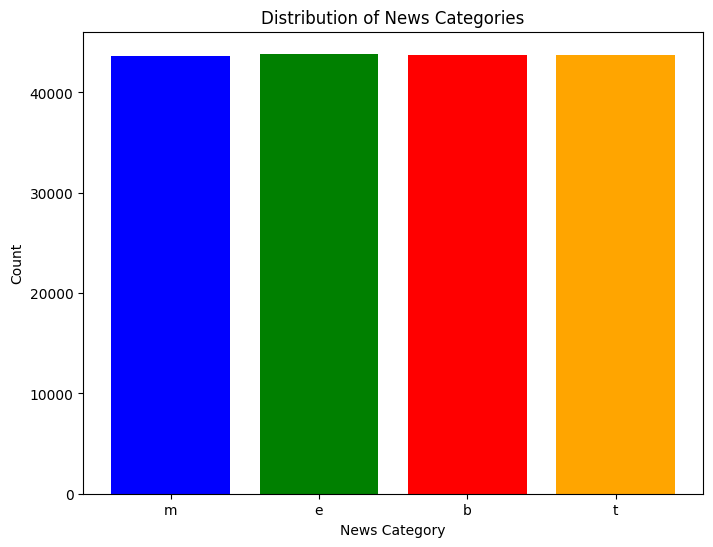

In [16]:
class_counts = df.groupBy("Category").count().toPandas()

plt.figure(figsize=(6, 4))
plt.bar(class_counts["Category"], class_counts["count"], color=['blue', 'green', 'red', 'orange'])
plt.xlabel("News Category")
plt.ylabel("Count")
plt.title("Distribution of News Categories")
plt.show()

## 5. Generating Word Embeddings with Word2Vec
A Word2Vec model is trained on the tokenized text to generate numerical vector representations for each title.

These embeddings capture semantic relationships between words, enabling more advanced analyses and machine learning applications.

The transformed dataset now includes a new column containing the computed feature vectors.

In [48]:
from pyspark.ml.feature import Word2Vec

word2Vec = Word2Vec(vectorSize=100, minCount=2, inputCol="filtered_words", outputCol="word_2_vec_features")
w2v_model = word2Vec.fit(df)
df = w2v_model.transform(df)

df.select("Title", "word_2_vec_features").show(5)

+--------------------+--------------------+
|               Title| word_2_vec_features|
+--------------------+--------------------+
|"22 jump street":...|[0.02605113020399...|
|"acid bath stem c...|[0.02982718311250...|
|"alice" from 'the...|[0.06149004162712...|
|"american idol" t...|[-0.0181223555700...|
|"avengers: age of...|[-0.0172859901795...|
+--------------------+--------------------+
only showing top 5 rows



## 6. Converting Text Labels to Numerical Indices
Since machine learning models require numerical inputs, the categorical 'Category' column is first transformed into numerical indices using StringIndexer, with the indices explicitly cast to integers to ensure compatibility.

Next, one-hot encoding is applied with dropLast=False to convert these indices into binary vectors of the correct size, ensuring that categorical features are represented numerically without implying an ordinal relationship.

In [19]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import col, udf
from pyspark.ml.linalg import SparseVector
from pyspark.sql.types import ArrayType, DoubleType

indexer = StringIndexer(inputCol="Category", outputCol="Category_index")
df = indexer.fit(df).transform(df).withColumn("Category_index", col("Category_index").cast("int"))

encoder = OneHotEncoder(inputCol="Category_index", outputCol="Category_onehot", dropLast=False)
df = encoder.fit(df).transform(df)

# Convert SparseVector to Dense Array
to_dense_udf = udf(lambda v: v.toArray().tolist() if isinstance(v, SparseVector) else v, ArrayType(DoubleType()))
df = df.withColumn("Category_onehot_dense", to_dense_udf(df["Category_onehot"]))

df.select("Category", "Category_index", "Category_onehot_dense").distinct().show()

+--------+--------------+---------------------+
|Category|Category_index|Category_onehot_dense|
+--------+--------------+---------------------+
|m       |3             |[0.0, 0.0, 0.0, 1.0] |
|t       |2             |[0.0, 0.0, 1.0, 0.0] |
|b       |1             |[0.0, 1.0, 0.0, 0.0] |
|e       |0             |[1.0, 0.0, 0.0, 0.0] |
+--------+--------------+---------------------+



# Model training

## 1. Training and Evaluating PySpark ML models


TrainingProcessor class is designed to handle model training, evaluation, and optional cross-validation, ensuring a scalable and reusable approach.

The training process supports **cross-validation**, which helps optimize model performance by tuning hyperparameters through multiple data splits.  

To ensure a thorough evaluation, multiple **classification metrics**, including accuracy, precision, recall, F1-score, and log loss—are calculated.

Finally, the pipeline integrates all steps into a **workflow**, automating the end-to-end process of model training and evaluation while allowing flexibility for model selection and hyperparameter tuning.

In [41]:
import time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from tqdm import tqdm


class TrainingProcessor:
    """
    A class to handle model training and evaluation with optional cross-validation.
    """

    def __init__(self, model, train_data, test_data, label_col):
        """
        Initializes the training processor.

        Args:
            model: PySpark ML model instance.
            train_data: Preprocessed training data.
            test_data: Preprocessed test data.
            label_col: Name of the label column.
        """
        self.model = model
        self.train_data = train_data
        self.test_data = test_data
        self.label_col = label_col

    def apply_cross_validation(self, param_grid, num_folds):
        """
        Applies cross-validation using the provided hyperparameter grid.

        Args:
            param_grid: Hyperparameter grid for tuning.
            num_folds: Number of folds for cross-validation.

        Returns:
            CrossValidator instance.
        """
        return CrossValidator(
            estimator=self.model,
            estimatorParamMaps=param_grid,
            evaluator=MulticlassClassificationEvaluator(labelCol=self.label_col, metricName="accuracy"),
            numFolds=num_folds
        )

    def train(self, use_cv=False, param_grid=None, num_folds=3, save_path=None):
        """
        Trains the model, optionally using cross-validation.

        Args:
            use_cv: Whether to use cross-validation (default: False).
            param_grid: Hyperparameter grid for tuning (default: None).
            num_folds: Number of folds for cross-validation (default: 3).
            save_path: Path to save the trained model (default: None).

        Returns:
            trained_model: The trained model.
            predictions: DataFrame with model predictions.
            train_time: Time taken for training.
            inference_time: Time taken for inference.
            train_loss: Training loss if available.
        """
        estimator = self.apply_cross_validation(param_grid, num_folds) if use_cv and param_grid else self.model
        print(f"Training {self.model}...")

        with tqdm(total=2, desc=f"{self.model} Progress", unit="step") as pbar:
            start_time = time.time()
            trained_model = estimator.fit(self.train_data)
            train_time = time.time() - start_time
            pbar.update(1)

            if isinstance(trained_model, CrossValidator):
                trained_model = trained_model.bestModel

            if save_path:
                trained_model.write().overwrite().save(save_path)
                print(f"Model saved at {save_path}")

            train_loss = None
            if hasattr(trained_model, "summary") and hasattr(trained_model.summary, "objectiveHistory"):
                train_loss = trained_model.summary.objectiveHistory[-1]

            start_time = time.time()
            predictions = trained_model.transform(self.test_data)
            inference_time = time.time() - start_time

        return trained_model, predictions, train_time, inference_time, train_loss

    def evaluate(self, predictions, train_time, inference_time, train_loss):
        """
        Evaluates the model's performance using accuracy, precision, recall, and F1-score.

        Args:
            predictions: DataFrame with model predictions.
            train_time: Time taken for training.
            inference_time: Time taken for inference.
            train_loss: Training loss if available.
        """
        accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=self.label_col, predictionCol="prediction", metricName="accuracy")
        log_loss_evaluator = MulticlassClassificationEvaluator(labelCol=self.label_col, predictionCol="prediction", metricName="logLoss")
        precision_evaluator = MulticlassClassificationEvaluator(labelCol=self.label_col, predictionCol="prediction", metricName="precisionByLabel")
        recall_evaluator = MulticlassClassificationEvaluator(labelCol=self.label_col, predictionCol="prediction", metricName="recallByLabel")
        f1_evaluator = MulticlassClassificationEvaluator(labelCol=self.label_col, predictionCol="prediction", metricName="f1")

        accuracy = accuracy_evaluator.evaluate(predictions)
        val_loss = log_loss_evaluator.evaluate(predictions)
        precision = precision_evaluator.evaluate(predictions)
        recall = recall_evaluator.evaluate(predictions)
        f1_score = f1_evaluator.evaluate(predictions)

        print(f"Training Time: {train_time:.2f}s")
        print(f"Inference Time: {inference_time:.2f}s")
        print(f"Training Loss: {train_loss:.4f}" if train_loss is not None else "Training Loss: Not Available")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

    def run_pipeline(self, use_cv=False, param_grid=None, num_folds=3, save_path=None):
        """
        Runs the training pipeline in the correct order: training, evaluation, and optionally cross-validation.

        Args:
            use_cv: Whether to use cross-validation (default: False).
            param_grid: Hyperparameter grid for tuning (default: None).
            num_folds: Number of folds for cross-validation (default: 3).
            save_path: Path to save the trained model (default: None).
        """
        trained_model, predictions, train_time, inference_time, train_loss = self.train(use_cv, param_grid, num_folds, save_path)
        self.evaluate(predictions, train_time, inference_time, train_loss)

## 2. Train/test splits
To ensure a reliable model evaluation, the dataset is randomly split into training (80%), validation (10%), and test (10%) subsets.

In [42]:
train_data, val_data, test_data = df.randomSplit([0.8, 0.1, 0.1], seed=42)

print(f"Train Size: {train_data.count()}, Validation Size: {val_data.count()}, Test Size: {test_data.count()}")

Train Size: 139901, Validation Size: 17352, Test Size: 17667


## 3. Logistic Regression

A parameter grid is constructed using ***ParamGridBuilder*** to systematically explore different hyperparameter combinations for the model.

The grid defines multiple values for ***regParam***, which controls the regularization strength, and ***elasticNetParam***, which balances between L1 (Lasso) and L2 (Ridge) regularization.

This approach enables an exhaustive search across specified hyperparameter ranges, facilitating the selection of the best configuration during cross-validation.

In [44]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder

lr = LogisticRegression(labelCol="Category_index", featuresCol="word_2_vec_features")

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.2]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

trainer = TrainingProcessor(lr, train_data, test_data, label_col="Category_index")

trainer.run_pipeline(use_cv=False, param_grid=param_grid, num_folds=3)

Training LogisticRegression_2e7d79e8f4cd...


LogisticRegression_2e7d79e8f4cd Progress:  50%|█████     | 1/2 [00:57<00:57, 57.22s/step]


Training Time: 57.06s
Inference Time: 0.13s
Training Loss: 0.4512
Accuracy: 0.8373
Precision: 0.8773
Recall: 0.8968
F1 Score: 0.8370
Validation Loss: 0.4483


## 4. Random Forest

The ***numTrees*** parameter, which determines the number of trees in the forest, is varied across 10, 50, and 100 to balance model complexity and performance.

The ***maxDepth*** parameter, which controls the maximum depth of each tree, is tested at values of 5, 10, and 15 to regulate model flexibility and prevent overfitting.

In [45]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder

rf = RandomForestClassifier(labelCol="Category_index", featuresCol="word_2_vec_features")

param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

training_processor = TrainingProcessor(model=rf, train_data=train_data, test_data=test_data, label_col="Category_index")

training_processor.run_pipeline(use_cv=False, param_grid=param_grid, num_folds=3)

Training RandomForestClassifier_ec27042de584...


RandomForestClassifier_ec27042de584 Progress:  50%|█████     | 1/2 [01:04<01:04, 64.62s/step]


Training Time: 64.50s
Inference Time: 0.11s
Training Loss: 0.0000
Accuracy: 0.7946
Precision: 0.7948
Recall: 0.8992
F1 Score: 0.7932
Validation Loss: 0.6900


## 5. Logistic Regression & Random Forest Models Summary



Prediction accuracy for ***logistic regression*** and ***random forest*** models, reaches values ranging from **0.75** to **0.85**, depending on fold and hyperparameters. Both models maintain a good tradeoff between **precision** and **recall** values.


To enhance those results, a larger, more complex model will be introduced in the next paragraph.




## 6. BiLSTM

The Bidirectional LSTM consists of an embedding layer for word representations, followed by two bidirectional LSTM layers that process text in both forward and backward directions.

Fully connected layers refine the learned features before producing final class probabilities using a softmax activation function.

The model is trained using sparse categorical cross-entropy loss and optimized with Adam.

Early stopping and model checkpointing ensure efficient training while preventing overfitting.

In [52]:
import time
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


class BiLSTMClassifier:
    def __init__(self, vocab_size=10000, max_len=50, num_classes=4):
        """
        Initializes the BiLSTM classifier with given hyperparameters.

        Args:
            vocab_size (int, optional): Vocabulary size. Defaults to 10000.
            max_len (int, optional): Maximum sequence length. Defaults to 50.
            num_classes (int, optional): Number of output classes. Defaults to 4.
        """
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.num_classes = num_classes
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds and compiles a Bidirectional LSTM model.

        Returns:
            Sequential: A compiled BiLSTM model.
        """
        model = Sequential([
            Embedding(input_dim=self.vocab_size, output_dim=128, input_length=self.max_len),
            Bidirectional(LSTM(128, return_sequences=True)),
            Bidirectional(LSTM(64)),
            Dense(16, activation="tanh"),
            Dense(self.num_classes, activation="softmax")
        ])
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, model_path="best_bilstm_model.h5"):
        """
        Trains the BiLSTM model on the given dataset.

        Args:
            X_train (array-like): Training input data.
            y_train (array-like): Training labels.
            X_val (array-like): Validation input data.
            y_val (array-like): Validation labels.
            epochs (int, optional): Number of training epochs. Defaults to 50.
            batch_size (int, optional): Batch size for training. Defaults to 32.
            model_path (str, optional): File path to save the best model. Defaults to "best_bilstm_model.h5".

        Returns:
            tuple: The trained model and training history.
        """
        early_stopping = EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True,
        )

        model_checkpoint = ModelCheckpoint(
            model_path,
            monitor="val_loss",
            save_best_only=True,
        )

        print("Training BiLSTM...")
        start_time = time.time()
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, model_checkpoint],
            verbose=1
        )
        train_time = time.time() - start_time
        print(f"\nTraining Time: {train_time:.2f}s")
        return self.model, history

    def predict(self, X):
        """
        Generates predictions using the trained BiLSTM model.

        Args:
            X (array-like): Input data to generate predictions for.

        Returns:
            array: Predicted class probabilities.
        """
        return self.model.predict(X)

    def evaluate(self, X_test, y_test):
        """
        Evaluates the trained model on test data.

        Args:
            X_test (array-like): Test input data.
            y_test (array-like): Test labels.

        Returns:
            tuple: Loss and accuracy metrics.
        """
        return self.model.evaluate(X_test, y_test)

    def compute_classification_metrics(self, X_test, y_test, class_labels):
        """
        Computes and displays classification metrics including classification report, confusion matrix, and ROC curve.

        Args:
            X_test (array-like): Test input data.
            y_test (array-like): True labels.
            class_labels (list): List of class labels.
        """
        y_pred_probs = self.predict(X_test)
        y_pred = y_pred_probs.argmax(axis=1)

        self._print_classification_report(y_test, y_pred, class_labels)
        self._plot_confusion_matrix(y_test, y_pred, class_labels)
        self._plot_roc_curve(y_test, y_pred_probs, class_labels)

    def plot_loss(self, history):
        """
        Plots the training and validation loss curves.

        Args:
            history: Training history object returned by model.fit().
        """
        plt.figure(figsize=(6, 4))
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.legend()
        plt.show()

    def _print_classification_report(self, y_test, y_pred, class_labels):
        """
        Prints the classification report.
        """
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=class_labels))

    def _plot_confusion_matrix(self, y_test, y_pred, class_labels):
        """
        Plots the confusion matrix.
        """
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def _plot_roc_curve(self, y_test, y_pred_probs, class_labels):
        """
        Plots the ROC curve for each class.
        """
        plt.figure(figsize=(8, 6))
        for i in range(len(class_labels)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

## Tokenize using TensorFlow Tokenizer, add Padding

This cell prepares textual and categorical data for a TensorFlow model, converting it from the Spark ML format. Since TensorFlow requires a different tokenizer format than Spark ML.

A Tokenizer is then initialized with a vocabulary size of 10,000 and an out-of-vocabulary (OOV) token to handle unseen words, as TensorFlow’s tokenization process differs from Spark ML’s.

The tokenizer is fitted on the filtered_words column, transforming text into sequences of integer tokens. These sequences are padded or truncated to a fixed length of 50 to ensure a uniform input size.

Finally, the categorical labels, originally in Spark ML’s one-hot encoding format, are converted into a NumPy array for compatibility with TensorFlow models.

In [28]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

pandas_df = df.select("filtered_words", "Category_onehot_dense").toPandas()

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(pandas_df["filtered_words"])

X = tokenizer.texts_to_sequences(pandas_df["filtered_words"])
X = pad_sequences(X, maxlen=50, padding="post", truncating="post")

y = np.array(pandas_df["Category_onehot_dense"].tolist(), dtype=np.int32)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train Size: {len(X_train)}, Validation Size: {len(X_val)}, Test Size: {len(X_test)}")

Train Size: 139936, Validation Size: 17492, Test Size: 17492


In [30]:
bilstm = BiLSTMClassifier(vocab_size=10000, max_len=50, num_classes=4)

model, history = bilstm.train(X_train, y_train, X_val, y_val, epochs=10, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training BiLSTM...
Epoch 1/10
4372/4373 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8256 - loss: 0.4513
Epoch 1: val_loss improved from inf to 0.24620, saving model to best_bilstm_model.h5


4373/4373 ━━━━━━━━━━━━━━━━━━━━ 71s 15ms/step - accuracy: 0.8256 - loss: 0.4512 - val_accuracy: 0.9130 - val_loss: 0.2462
Epoch 2/10
4369/4373 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9326 - loss: 0.1912
Epoch 2: val_loss improved from 0.24620 to 0.23130, saving model to best_bilstm_model.h5


4373/4373 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - accuracy: 0.9326 - loss: 0.1912 - val_accuracy: 0.9185 - val_loss: 0.2313
Epoch 3/10
4371/4373 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9480 - loss: 0.1445
Epoch 3: val_loss did not improve from 0.23130
4373/4373 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - accuracy: 0.9480 - loss: 0.1445 - val_accuracy: 0.9169 - val_loss: 0.2488
Epoch 4/10
4373/4373 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9593 - loss: 0.1106
Epoch 4: val_loss did not improve from 0.23130
4373/4373 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - accuracy: 0.9593 - loss: 0.1106 - val_accuracy: 0.9172 - val_loss: 0.2617
Epoch 5/10
4373/4373 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9685 - loss: 0.0854
Epoch 5: val_loss did not improve from 0.23130
4373/4373 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - accuracy: 0.9685 - loss: 0.0854 - val_accuracy: 0.9153 - val_loss: 0.3034
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

Training Time: 414.38s


# Results

In [31]:
class_labels = ["Entertainment", "Business", "Technology", "Health"]

## BiLSTM

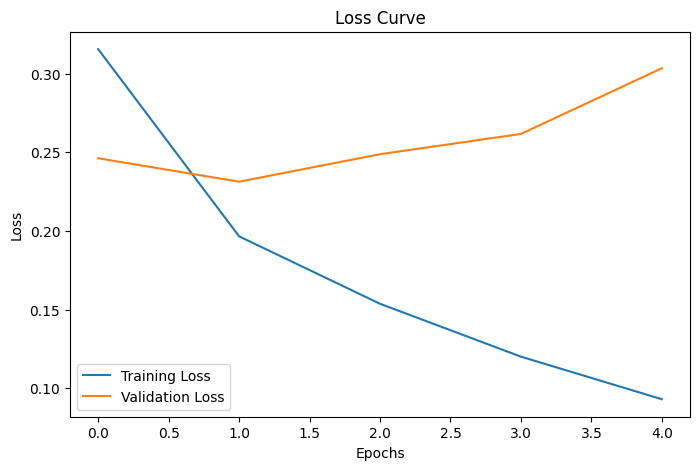

In [34]:
bilstm.plot_loss(history)

547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
               precision    recall  f1-score   support

     Business       0.95      0.94      0.95      4484
   Technology       0.91      0.88      0.89      4324
Entertainment       0.89      0.91      0.90      4299
       Health       0.93      0.95      0.94      4385

     accuracy                           0.92     17492
    macro avg       0.92      0.92      0.92     17492
 weighted avg       0.92      0.92      0.92     17492



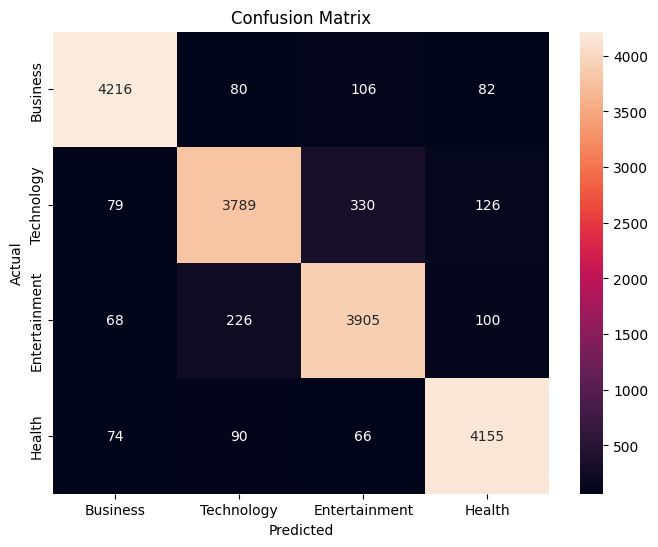

In [54]:
y_test = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test).argmax(axis=1)

bilstm.compute_classification_metrics(X_test, y_test, class_labels=class_labels)

## Summary

* The loss converges very well, with the model performing at a maximum accuracy of **0.9685**, which is a good result for a production model.

* Most of the mistakes were related to confusing **Entertainment** and **Technology** categories.

* This could be improved in further iterations, by adding more data representing these categories.

* Additionally, more combinations of hyperparameters, including different model sizes could be tested to streamline inference and training time as well as predictive capabilities.

# Further Improvements for the Experiment
* Apply stemming or lemmatization to normalize words and reduce variations in vocabulary.

* Experiment with TF-IDF, pre-trained embeddings (e.g., GloVe, BERT), or n-grams to improve text representation.

* Adjust Word2Vec parameters such as vector size, window size, and minCount for optimal performance.

* Use SMOTE (Synthetic Minority Over-sampling Technique) or stratified sampling instead of simple undersampling to maintain data diversity.

* Visualize word distributions, category frequencies, and feature correlations to uncover deeper insights before modeling.

* Identify and remove anomalies in the dataset that could skew model performance.

* Extract additional meaningful features from the dataset, such as text length or sentiment scores, to enhance predictive power.

* Explore more models to find the best accuracy, inference time and training time tradeoff.






